# 📘 DeepSeek-OCR Baseline Inference

## 1. Installation

In [ ]:
# 1. Cài đặt Unsloth & Dependencies
!pip install --no-deps bitsandbytes accelerate xformers peft trl triton cut_cross_entropy unsloth_zoo
!pip install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" "hf_transfer"
!pip install --no-deps unsloth

# 2. Cài đặt Transformers & TRL đúng version yêu cầu
!pip install transformers==4.56.2
!pip install --no-deps trl==0.22.2

# 3. Thư viện hỗ trợ
!pip install jiwer einops addict easydict torchvision

In [2]:
# 1. Cài đặt các thư viện lõi (Core libraries)
import os, sys

# Thiết lập biến môi trường để Unsloth chạy mượt mà
os.environ["UNSLOTH_WARN_UNINITIALIZED"] = '0'

## 2. Load Model & LoRA config

In [ ]:
import torch
from unsloth import FastVisionModel
from transformers import AutoModel
from huggingface_hub import snapshot_download

# 1. Tải model về thư mục local "deepseek_ocr"
print("⬇️ Đang tải model DeepSeek-OCR...")
snapshot_download("unsloth/DeepSeek-OCR", local_dir = "deepseek_ocr")

# 2. Load Model từ thư mục local
# Sử dụng load_in_4bit=True cho GPU T4
model, tokenizer = FastVisionModel.from_pretrained(
    "./deepseek_ocr",
    load_in_4bit = True, 
    auto_model = AutoModel,
    trust_remote_code = True,
    unsloth_force_compile = True,
    use_gradient_checkpointing = "unsloth", 
)

# 3. Gắn LoRA Adapters
model = FastVisionModel.get_peft_model(
    model,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None, 
)

print("✅ Load model thành công!")

## 3. Inference

In [4]:
import json
import random
import os
from PIL import Image
import matplotlib.pyplot as plt
import jiwer
import pandas as pd


# Tạo thư mục output để tránh lỗi "No such 
OUTPUT_DIR = "/kaggle/working/output"
os.makedirs(OUTPUT_DIR, exist_ok=True)

# 1. Hàm tính Character Error Rate (CER)
def calculate_cer(reference, hypothesis):
    """
    Tính Character Error Rate (CER) với chuẩn hóa văn bản
    """
    # 1. Chuẩn hóa dữ liệu 
    # Strip: xoá khoảng trắng thừa đầu cuối
    # Lower: đưa về chữ thường 
    ref = reference.strip().lower()
    hyp = hypothesis.strip().lower()
    
    # 2. Xử lý các trường hợp đặc biệt
    if not ref:
        if not hyp:
            return 0.0  # Cả 2 cùng rỗng -> Model đoán đúng -> Lỗi 0%
        else:
            return 1.0  # Nhãn rỗng nhưng Model đoán ra chữ -> 100%
            
    # 3. Tính CER
    return jiwer.cer(ref, hyp)
    
# 2. Hàm chạy baseline infer trên một số mẫu ngẫu nhiên từ file JSONL (nếu num_samples được chỉ định)
def run_baseline_infer(jsonl_path, num_samples=None):
    print(f"📂 Đang đọc dữ liệu từ: {jsonl_path}")
    
    if not os.path.exists(jsonl_path):
        print(f"❌ Không tìm thấy file: {jsonl_path}")
        return

    with open(jsonl_path, 'r', encoding='utf-8') as f:
        lines = f.readlines()
    
    if not lines:
        print("❌ File rỗng!")
        return

    # Lấy mẫu ngẫu nhiên nếu num_samples được chỉ định còn không thì dùng tất cả
    samples = random.sample(lines, min(len(lines), num_samples)) if num_samples is not None else lines

    # Instruction mặc định của DeepSeek-OCR
    instruction = "<image>\nFree OCR. "

    result = []
    total_cer = 0.0
    count = 0
    
    for i, line in enumerate(samples):
        data = json.loads(line)
        img_path = data["image"]
        # get name of mother folder of img_path
        img_folder = os.path.basename(os.path.dirname(img_path))
        # get name of img_path
        img_name = os.path.basename(img_path)
        ground_truth = data["text"]

        try:

            # Chạy Inference
            res = model.infer(
                tokenizer, 
                prompt=instruction, 
                image_file=img_path,       
                output_path=OUTPUT_DIR + f"/{img_folder}/{img_name}",    
                base_size=1024, 
                image_size=640, 
                crop_mode=True, 
                save_results=True,         
                test_compress=False
            )
            
            # Xử lý kết quả trả về
            # pred_text đọc từ output_path/result.mmd
            pred_text = ""
            with open(OUTPUT_DIR + f"/{img_folder}/{img_name}/result.mmd", 'r', encoding='utf-8') as f:
                pred_text = f.read().strip()

            # tính CER
            cer = calculate_cer(ground_truth, pred_text)
            total_cer += cer
            count += 1

            # Lưu kết quả
            result.append({
                "image": img_path,
                "ground_truth": ground_truth,
                "prediction": pred_text,
                "cer": cer
            })
            
        except Exception as e:
            print(f"❌ Lỗi: {e}")

    avg_cer = total_cer / count if count > 0 else None
    return pd.DataFrame(result), avg_cer, count

print("✅ Đã chuẩn bị hàm Inference")

✅ Đã chuẩn bị hàm Inference


In [5]:
# Đường dẫn tới file JSONL để check được convert trước đó
TEST_JSONL = "/kaggle/input/uit-hwdb/test_line.jsonl" 

In [ ]:
# Chạy baseline infer trên tập test của UIT-HWDB (line)
result = None
avg_cer = None
count = 0
if os.path.exists(TEST_JSONL):
    result, avg_cer, count = run_baseline_infer(TEST_JSONL, num_samples=None) # inference trên tất cả mẫu
else:
    print(f"⚠️ Không tìm thấy file {TEST_JSONL}")

## 4. Result

### Summary

In [7]:
# Lưu kết quả ra file CSV
if result is not None:
    result.to_csv("/kaggle/working/deepseek_ocr_baseline_results.csv", index=False)
    print("✅ Kết quả đã được lưu vào 'deepseek_ocr_baseline_results.csv'")

✅ Kết quả đã được lưu vào 'deepseek_ocr_baseline_results.csv'


In [8]:
# Tổng hợp 
print(f"\n{'='*40}")
print(f"📊 KẾT QUẢ ĐÁNH GIÁ (Trên {count} mẫu)")
print(f"🎯 Average CER: {avg_cer:.4f}")
print(f"   - Tức là sai khoảng {avg_cer*100:.2f}% số ký tự")
print(f"{'='*40}\n")


📊 KẾT QUẢ ĐÁNH GIÁ (Trên 201 mẫu)
🎯 Average CER: 1.0569
   - Tức là sai khoảng 105.69% số ký tự



### Visualization

---------- 🌟 Top 5 mẫu CER thấp nhất ----------

-------------------- Mẫu #143 --------------------


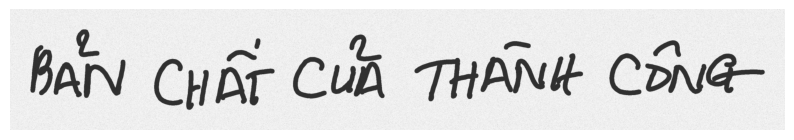

✅ Ground Truth: BẢN CHẤT CỦA THÀNH CÔNG
🤖  Prediction  : Bản chất của thành công
📝 CER         : 0.0000

-------------------- Mẫu #166 --------------------


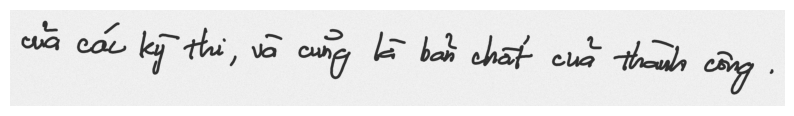

✅ Ground Truth: của các kỳ thi, và cũng là bản chất của thành công.
🤖  Prediction  : của các ký thú, và cũng là bản chất của thành công.
📝 CER         : 0.0392

-------------------- Mẫu #174 --------------------


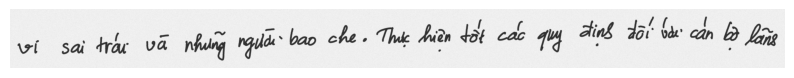

✅ Ground Truth: vi sai trái và những người bao che. Thực hiện tốt các quy định đối với cán bộ lãnh
🤖  Prediction  : vì sai trai và nhúng người bao che. Thực hiện tốt các quy định đối với cán bộ liên
📝 CER         : 0.0732

-------------------- Mẫu #69 --------------------


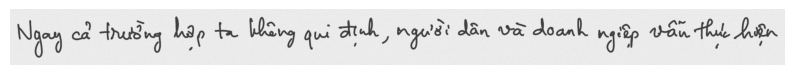

✅ Ground Truth: Ngay cả trường hợp ta không qui định, người dân và doanh nghiệp vẫn thực hiện
🤖  Prediction  : Ngay cũ trường hẹp tư liêng qui định, người dân và doanh nghiệp vẫn thực hiện
📝 CER         : 0.0779

-------------------- Mẫu #121 --------------------


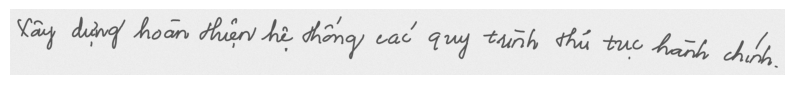

✅ Ground Truth: Xây dựng hoàn thiện hệ thống các qui trình thủ tục hành chính.
🤖  Prediction  : Kaiy dùng hoàn thiện hệ thống các quy trình thủ tục hành chính.
📝 CER         : 0.0806


In [9]:
# Top 5 cer thấp nhất
top_n = min(5, len(result))
top_cer_results = result.nsmallest(top_n, 'cer')
print(f"---------- 🌟 Top {top_n} mẫu CER thấp nhất ----------")
for idx, row in top_cer_results.iterrows():
    print(f"\n-------------------- Mẫu #{idx+1} --------------------")
    # Hiển thị ảnh
    img_path = row['image']
    if os.path.exists(img_path):
        image_preview = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(10, 2))
        plt.imshow(image_preview)
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ Không tìm thấy file ảnh: {img_path}")
        continue
    print(f"✅ Ground Truth: {row['ground_truth']}")
    print(f"🤖  Prediction  : {row['prediction']}")
    print(f"📝 CER         : {row['cer']:.4f}")

---------- 🚨 Top 5 mẫu CER cao nhất ----------
-------------------- Mẫu #24 --------------------


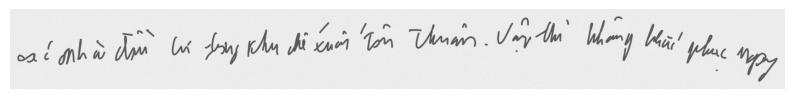

✅ Ground Truth: các nhà đầu tư trong Khu chế xuất Tân Thuận. Vậy thì khi không khắc phục ngay
🤖  Prediction  : салчын дүнүн кур болгон дүн сүнүн "Тонн Чынын" үнүн чынын дүнүн "Тонн Чынын" үнүн чынум дүнүн "Тонн Чынын" үнүн чындын дүнүн "Тонн Чынын" үнүн дүнүн "Тонн Чынын" үнүн "Тонн Чынын" үнүн "Тоннын" үнүн "Тоннын" үнүн "Тонын" үнүн "Тонын" үнүн "Тоннын" үнүн "Тонын" үнүн "Тоннын" үнүн "Тоның" үнүн "Тоннын" үнүн "Тоңнын" үнүн "Тоңнын" үнүн "тоңнын" үнүн "Тоңнын" үнүн үнүн "Тоңнын" үнүн үнүн үнүн "Тоңнын" үнүн "Тоңын" үнүн "Тоңын" үнүн үнүн үнүн үнүн үнүн үнүрүн үнүн үнүн үнүн үнүн үүнүн үнүн үнүн үнүн үнүн "Тоңнын"үнүн үнүн үнүн үнүн үнүр үнүн үнүн үнүн үнүн үнүүн үнүн үнүн үнүн үнүн үңүн үнүн үнүн үнүн үнүн үчүн үнүн үнүн үнүн үнүн үрүн үнүн үнүн үнүн үнүн "тоңнын"үнүн үнүн үнүн үнүрүн үн үнүн үнүн үнүн үнүн үн үнүн үнүн үнүн үнүрүнүн үнүн үнүн үнүн үнүүрүнүн үнүн үнүн үнүн үүнүрүнүн үнүн үнүн үнүнүн үнүн үнүн үнүн үнүңүнүн үнүн үнүн үнүн үнүкүнүн үнүн үнүн үнүн үнүсүнүн үнүн үнүн ү

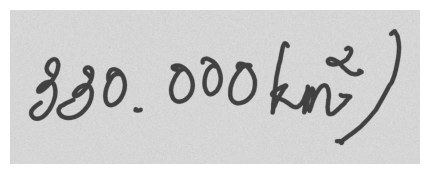

✅ Ground Truth: 330.000 km2)
🤖  Prediction  : \[ 330.000 \, \text{km}^2 \]
📝 CER         : 1.4167
-------------------- Mẫu #29 --------------------


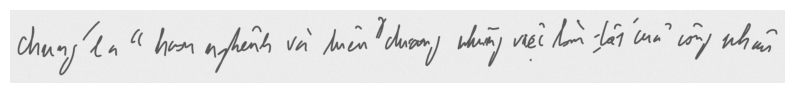

✅ Ground Truth: Chúng ta " hoan nghênh và biểu dương những việc làm tốt của công nhân
🤖  Prediction  : chuyện là có hơn nghènh vì nên Chương chuyện nói là là là là là là là là là là là là là là là là là là là là
📝 CER         : 1.1304
-------------------- Mẫu #58 --------------------


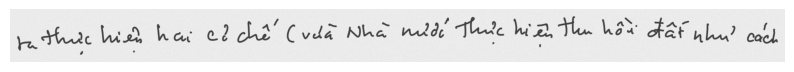

✅ Ground Truth: ta thực hiện hai cơ chế (vừa Nhà nước thực hiện thu hồi đất như cách
🤖  Prediction  : на что ни к чему, если сонно, когда надо, то что ни в чем не дано, что ни в чем нет.
📝 CER         : 1.0294
-------------------- Mẫu #68 --------------------


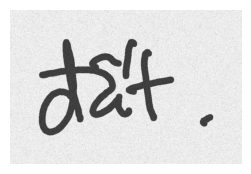

✅ Ground Truth: đất.
🤖  Prediction  : 书法
📝 CER         : 1.0000


In [10]:
# Top 5 cer cao nhất
top_cer_results = result.nlargest(top_n, 'cer')
print(f"---------- 🚨 Top {top_n} mẫu CER cao nhất ----------")
for idx, row in top_cer_results.iterrows():
    print(f"-------------------- Mẫu #{idx+1} --------------------")
    # Hiển thị ảnh
    img_path = row['image']
    if os.path.exists(img_path):
        image_preview = Image.open(img_path).convert("RGB")
        plt.figure(figsize=(10, 2))
        plt.imshow(image_preview)
        plt.axis('off')
        plt.show()
    else:
        print(f"⚠️ Không tìm thấy file ảnh: {img_path}")
        continue
    print(f"✅ Ground Truth: {row['ground_truth']}")
    print(f"🤖  Prediction  : {row['prediction']}")
    print(f"📝 CER         : {row['cer']:.4f}")
